In [1]:
from torchvision import datasets, transforms
import torch

In [2]:
pca_components = 4

# Data Preparation

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                    transform=transform)
train_kwargs = {'batch_size': 32, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_kwargs = {'batch_size': 1024, 'shuffle': False, 'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [4]:
import numpy as np
from sklearn.decomposition import PCA

# Convert data loaders to numpy arrays for PCA
X_train = []
y_train = []
X_test = []
y_test = []

# Extract data from train loader
for data, target in train_loader:
    X_train.append(data.numpy().reshape(data.shape[0], -1))
    y_train.append(target.numpy())

# Extract data from test loader
for data, target in test_loader:
    X_test.append(data.numpy().reshape(data.shape[0], -1))
    y_test.append(target.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Apply PCA
pca = PCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# normalize each feature to [0, 1]
X_train_pca = (X_train_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))
X_test_pca = (X_test_pca - X_test_pca.min(axis=0)) / (X_test_pca.max(axis=0) - X_test_pca.min(axis=0))

# Convert back to PyTorch tensors and create new data loaders
X_train_pca = torch.FloatTensor(X_train_pca)
X_test_pca = torch.FloatTensor(X_test_pca)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
X_train_pca[0:3]

tensor([[0.4703, 0.7739, 0.6959, 0.5439],
        [0.4790, 0.1546, 0.5864, 0.3751],
        [0.1776, 0.5688, 0.5342, 0.6394]])

In [6]:
y_train[0:10]

tensor([3, 4, 3, 8, 8, 5, 2, 2, 6, 4])

In [7]:
# only take items where y is 1 or 5
mask_train = (y_train == 1) | (y_train == 5)
mask_test = (y_test == 1) | (y_test == 5)
X_train_pca = X_train_pca[mask_train]
y_train = y_train[mask_train]
X_test_pca = X_test_pca[mask_test]
y_test = y_test[mask_test]

# convert y_train and y_test to 0 and 1 from 1 and 5
y_train = (y_train == 1).long()
y_test = (y_test == 1).long()

# Create TensorDataset
train_dataset = torch.utils.data.TensorDataset(X_train_pca, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test_pca, y_test)

# Create new data loaders with PCA-transformed data
train_loader_pca = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader_pca = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: [0.09704388 0.07096101 0.06169181 0.05389266]
Total variance explained: 0.2836


In [8]:
# smaller dataset with only a few samples
small_size = 32*32
small_train_dataset = torch.utils.data.TensorDataset(X_train_pca[:small_size], y_train[:small_size])
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, **train_kwargs)
small_test_dataset = torch.utils.data.TensorDataset(X_test_pca[:small_size], y_test[:small_size])
small_test_loader = torch.utils.data.DataLoader(small_test_dataset, **test_kwargs)

In [9]:
del X_train, X_test, X_train_pca, X_test_pca

In [10]:
x_sample = small_train_dataset[0][0]
y_sample = small_train_dataset[0][1]
print(f"Sample PCA data point: {x_sample}")
print(f"Sample label: {y_sample.item()}")

Sample PCA data point: tensor([0.2848, 0.4660, 0.3286, 0.6944])
Sample label: 0


# Pasqal Model Preparation

In [11]:
import torch
from torch import Tensor

from typing import Callable

from pulser import Sequence, Pulse, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, CustomWaveform, ConstantWaveform

from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param
from pulser_diff.utils import IMAT, ZMAT, kron

import matplotlib.pyplot as plt
from scipy import interpolate

from pyqtorch.utils import SolverType
from pulser.register.register_layout import RegisterLayout

In [12]:
def state_to_output(state: Tensor) -> Tensor:
    """
    Convert the final state of the system to a binary output.
    Here we assume that the output is 1 if the magnetization is positive,
    and 0 if it is negative.
    """
    magnetization = state.real.mean(dim=0)
    n_qubits = magnetization.shape[0]

    # Normalize the magnetization to [0, 1]
    out = (magnetization + n_qubits) / (2 * n_qubits)
    return out

In [13]:
# now all in one function
def run_model(x: Tensor, positions: Tensor, local_pulses_omega: Tensor, local_pulses_delta: Tensor,
              global_pulse_omega: Tensor, global_pulse_delta: Tensor, global_pulse_duration=500, local_pulse_duration=250, embed_pulse_duration=250, 
              sampling_rate=0.5,
              draw_reg_seq:bool = True) -> Tensor:
    """
    Run the model with the given parameters and return the output.
    Args:
        x (Tensor): Input data, PCA components.
        positions (Tensor): Positions of the qubits in the register.
        local_pulses_omega (Tensor): Amplitudes of the local pulses. (shape: (pca_components,))
        local_pulses_delta (Tensor): Detunings of the local pulses. (shape: (pca_components,))
        global_pulse_omega (Tensor): Amplitude of the global pulse. (shape: ())
        global_pulse_delta (Tensor): Detuning of the global pulse. (shape: ())
    """
    reg = Register({"q" + str(i): pos for i, pos in enumerate(positions)})
    seq = Sequence(reg, MockDevice)
    seq.declare_channel("rydberg_global", "rydberg_global")
    seq.declare_channel("rydberg_local_q0", "rydberg_local")
    seq.target(f"q0", channel="rydberg_local_q0")
    seq.declare_channel("rydberg_local_q1", "rydberg_local")
    seq.target(f"q1", channel="rydberg_local_q1")
    seq.declare_channel("rydberg_local_q2", "rydberg_local")
    seq.target(f"q2", channel="rydberg_local_q2")
    seq.declare_channel("rydberg_local_q3", "rydberg_local")
    seq.target(f"q3", channel="rydberg_local_q3")



    # make sure omegas are > 0
    global_pulse_omega = torch.abs(global_pulse_omega)
    local_pulses_omega = torch.abs(local_pulses_omega)

    # embed PCA components into the register through local pulses
    # x is already in the range [0, 1] due to normalization
    for i in range(pca_components):
        pulse_local = Pulse.ConstantPulse(embed_pulse_duration, 1000*x[i]*np.pi / embed_pulse_duration, 0.0, 0.0)  # Use x[i] as the amplitude
        seq.add(pulse_local, f"rydberg_local_q{i}", protocol="min-delay")
        
    # global pulse
    pulse_global = Pulse.ConstantPulse(global_pulse_duration, 
                                       global_pulse_omega*np.pi*1000/global_pulse_duration, 
                                       global_pulse_delta*np.pi*1000/global_pulse_duration,
                                       0.0)
    seq.add(pulse_global, "rydberg_global")
    seq.declare_variable("omega_global")
    seq.declare_variable("delta_global")

    # local pulses
    for i in range(pca_components):
        pulse_local = Pulse.ConstantPulse(local_pulse_duration, 
                                          local_pulses_omega[i]*np.pi*1000/local_pulse_duration, 
                                          local_pulses_delta[i]*np.pi*1000/local_pulse_duration,
                                          0.0)
        seq.add(pulse_local, f"rydberg_local_q{i}", protocol="min-delay")
        seq.declare_variable(f"omega_q{i}")
        seq.declare_variable(f"delta_q{i}")

    # global pulse
    pulse_global = Pulse.ConstantPulse(global_pulse_duration, 
                                       global_pulse_omega*np.pi*1000/global_pulse_duration, 
                                       global_pulse_delta*np.pi*1000/global_pulse_duration,
                                       0.0)
    seq.add(pulse_global, "rydberg_global")
    seq.declare_variable("omega1_global")
    seq.declare_variable("delta1_global")

    # local pulses
    for i in range(pca_components):
        # pulse_local = Pulse.ConstantPulse(local_pulse_duration, 
        #                                   local_pulses_omega[i]*np.pi*1000/local_pulse_duration, 
        #                                   local_pulses_delta[i]*np.pi*1000/local_pulse_duration,
        #                                   0.0)
        pulse_local = Pulse.ConstantPulse(embed_pulse_duration, 1000*x[i]*np.pi / embed_pulse_duration, 0.0, 0.0)  # Use x[i] as the amplitude
        seq.add(pulse_local, f"rydberg_local_q{i}", protocol="min-delay")
        seq.declare_variable(f"omega2_q{i}")
        seq.declare_variable(f"delta2_q{i}")

    # global pulse
    pulse_global = Pulse.ConstantPulse(global_pulse_duration, 
                                       global_pulse_omega*np.pi*1000/global_pulse_duration, 
                                       global_pulse_delta*np.pi*1000/global_pulse_duration,
                                       0.0)
    seq.add(pulse_global, "rydberg_global")
    seq.declare_variable("omega2_global")
    seq.declare_variable("delta2_global")
    # local pulses
    for i in range(pca_components):
        pulse_local = Pulse.ConstantPulse(local_pulse_duration, 
                                          local_pulses_omega[i]*np.pi*1000/local_pulse_duration, 
                                          local_pulses_delta[i]*np.pi*1000/local_pulse_duration,
                                          0.0)
        seq.add(pulse_local, f"rydberg_local_q{i}", protocol="min-delay")
        seq.declare_variable(f"omega3_q{i}")
        seq.declare_variable(f"delta3_q{i}")

    # global pulse
    pulse_global = Pulse.ConstantPulse(global_pulse_duration, 
                                       global_pulse_omega*np.pi*1000/global_pulse_duration, 
                                       global_pulse_delta*np.pi*1000/global_pulse_duration,
                                       0.0)
    seq.add(pulse_global, "rydberg_global")
    seq.declare_variable("omega3_global")
    seq.declare_variable("delta3_global")

    if draw_reg_seq:
        reg.draw(with_labels=True, draw_half_radius=True, blockade_radius=MockDevice.rydberg_blockade_radius(1.0))
        seq.draw()

    sim = TorchEmulator.from_sequence(seq, sampling_rate=sampling_rate)
    results = sim.run(time_grad=True, dist_grad=True, solver=SolverType.DP5_SE)

    return state_to_output(results.states[-1]), results.states

tensor([[12.2500, -2.5000],
        [-8.7500,  3.5000],
        [ 2.2500,  5.5000],
        [-5.7500, -6.5000]], dtype=torch.float64, requires_grad=True)


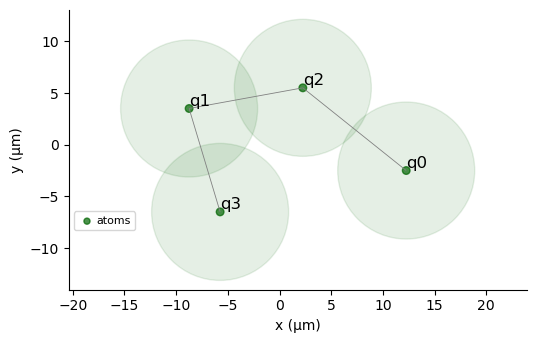

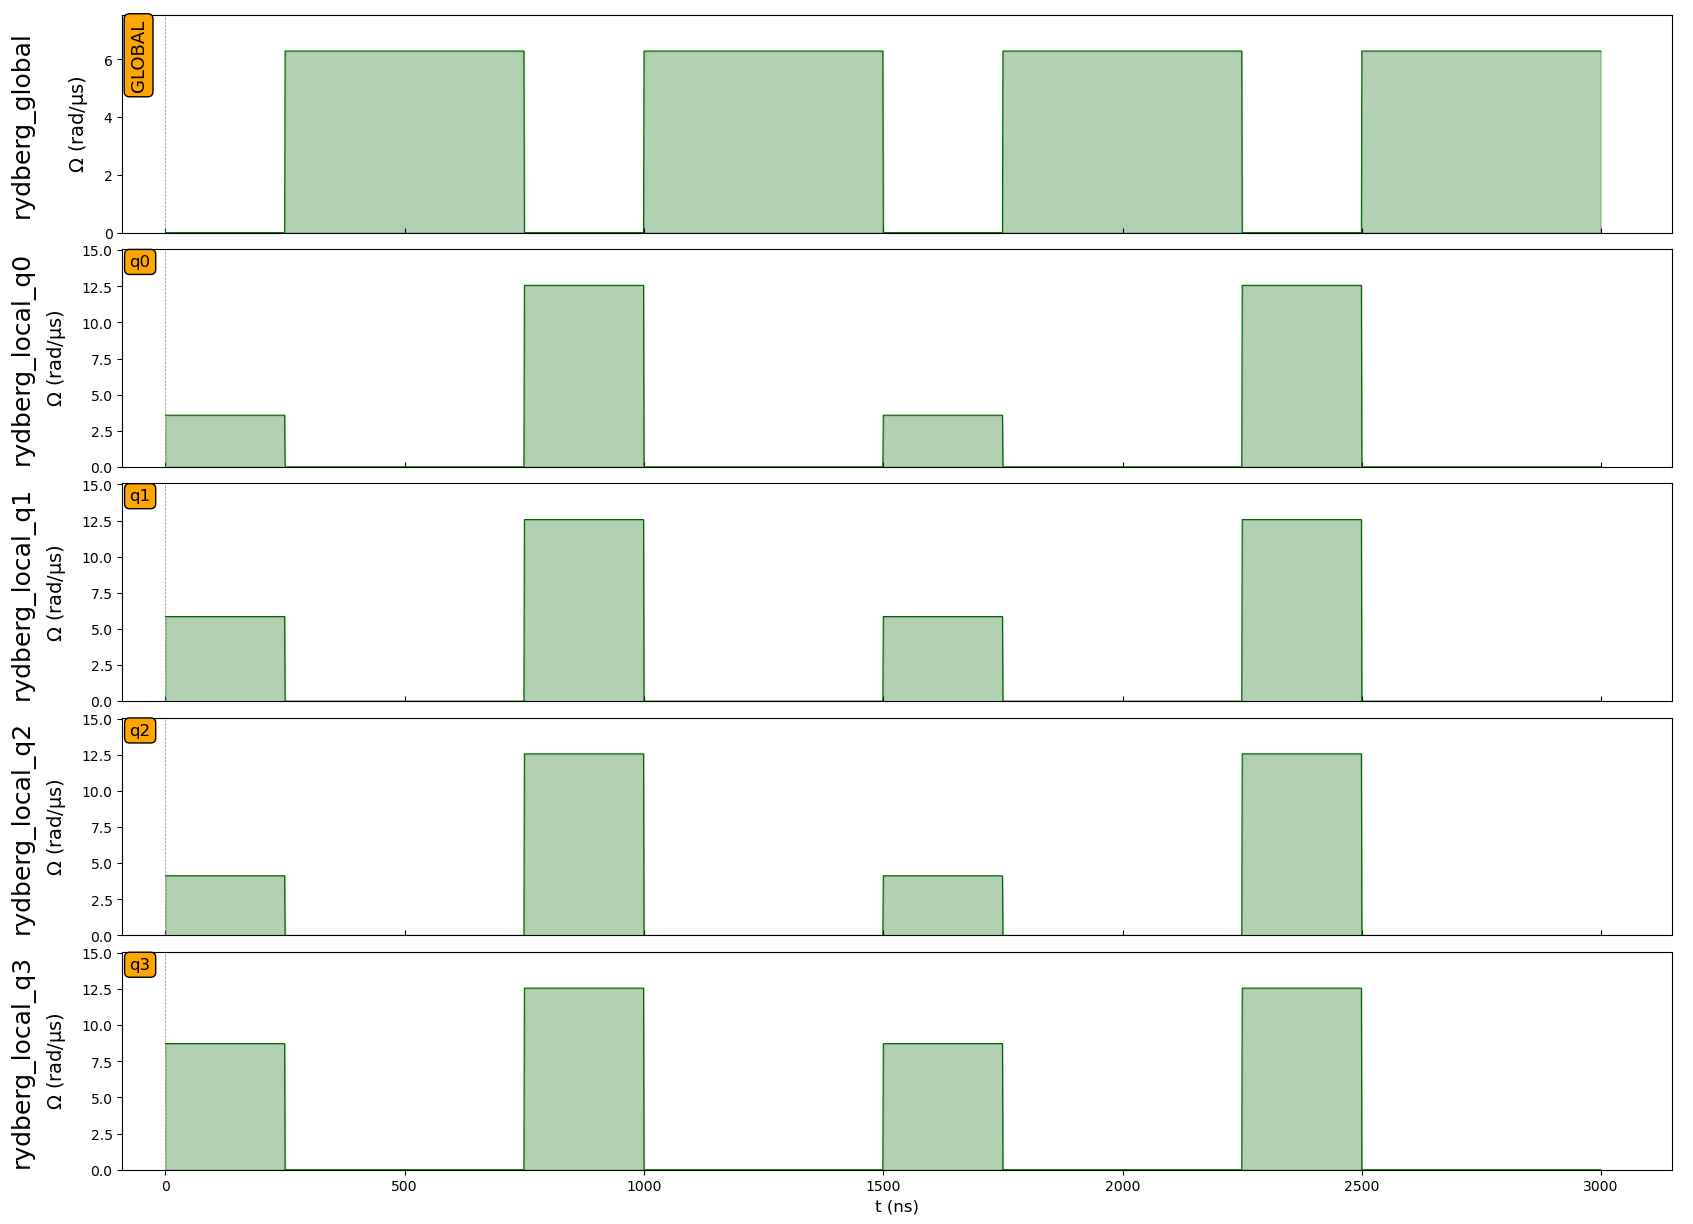

In [14]:
# test the model
np.random.seed(42)  # Keeps results consistent between runs
positions = np.random.randint(0, 38, size=(pca_components, 2))
positions = positions - np.mean(positions, axis=0)
positions = torch.tensor(positions, requires_grad=True)
print(positions)

local_pulses_omega = torch.tensor([1.0] * pca_components, dtype=torch.float32, requires_grad=True)
local_pulses_delta = torch.tensor([0.0] * pca_components, dtype=torch.float32, requires_grad=True)
global_pulse_omega = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
global_pulse_delta = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

out = run_model(small_train_dataset[0][0], positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta, draw_reg_seq=True)

In [15]:
from pathlib import Path
import os

In [16]:
np.random.seed(42)  # Keeps results consistent between runs
positions = np.random.randint(0, 38, size=(pca_components, 2))
positions = positions - np.mean(positions, axis=0)
positions = torch.tensor(positions, requires_grad=True)
print("start positions:", positions)

local_pulses_omega = torch.tensor([1.0] * pca_components, dtype=torch.float32, requires_grad=True)
local_pulses_delta = torch.tensor([0.5] * pca_components, dtype=torch.float32, requires_grad=True)
global_pulse_omega = torch.tensor(0.7, dtype=torch.float32, requires_grad=True)
global_pulse_delta = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
data_save_dir = Path("generated_data") / "4_pca_components" / "1"
data_save_file = data_save_dir / "output.csv"
os.makedirs(data_save_dir, exist_ok=True)

# define loss function and optimizer
# loss_fn = torch.nn.MSELoss()
epochs = 50
lr = 0.01
sampling_rate = 0.8
local_pulse_duration = 50
global_pulse_duration = 50
embed_pulse_duration = 50

# save header to file
with open(data_save_file, 'w') as f:
    f.write("sampling_rate;local_pulse_duration;global_pulse_duration;embed_pulse_duration;positions;local_pulses_omega;local_pulses_delta;global_pulse_omega;global_pulse_delta;states;total_magnetization;x;y\n")

loss_fn = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
parameters = [positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta]
optimizer = torch.optim.Adam(parameters, lr=lr)

losses_hist = [] # list to store losses for each batch
accuracies_hist = []
positions_hist = [positions.clone().detach().numpy()]  # list to store positions for each epoch
local_pulses_omega_hist = [local_pulses_omega.clone().detach().numpy()]  # list to store local pulses omega for each epoch
local_pulses_delta_hist = [local_pulses_delta.clone().detach().numpy()]  # list to store local pulses delta for each epoch
global_pulse_omega_hist = [global_pulse_omega.clone().detach().numpy()]  # list to store global pulse omega for each epoch
global_pulse_delta_hist = [global_pulse_delta.clone().detach().numpy()]  # list to store global pulse delta for each epoch

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i_batch, batch in enumerate(small_train_loader):
        print(f"Batch {i_batch+1}/{len(small_train_loader)}")
        x_batch, y_batch = batch
        optimizer.zero_grad()
        l = torch.tensor(0.0, requires_grad=False)
        y_pred_batch = []
        for i in range(len(x_batch)):
            print(f"Processing sample {i+1}/{len(x_batch)}", end='\r')
            out, states = run_model(x_batch[i], positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta,
                            local_pulse_duration=local_pulse_duration, global_pulse_duration=global_pulse_duration, 
                            embed_pulse_duration=embed_pulse_duration,
                            draw_reg_seq=False)
            loss = loss_fn(out, y_batch[i:i+1].to(torch.float64)) # needs float64 here
            y_pred_batch.append(out.item())
            l += loss
            # save parameters and output to file
            with open(data_save_file, 'a') as f:
                # f.write(f"{positions.tolist()};{local_pulses_omega.tolist()};{local_pulses_delta.tolist()}; {global_pulse_omega.item()};{global_pulse_delta.item()};{states[-1].tolist()};{out.item()};{x_batch[i].tolist()};{y_batch[i].item()}\n")
                f.write(f"{sampling_rate};{local_pulse_duration};{global_pulse_duration};{embed_pulse_duration};"
                        f"{positions.tolist()};{local_pulses_omega.tolist()};{local_pulses_delta.tolist()};"
                        f"{global_pulse_omega.item()};{global_pulse_delta.item()};{states[-1].tolist()};"
                        f"{out.item()};{x_batch[i].tolist()};{y_batch[i].item()}\n")

        l /= len(x_batch)
        l.backward()
        optimizer.step()
        losses_hist.append(l.item())
        positions_hist.append(positions.clone().detach().numpy())
        # calculate accuracy for the batch
        targets = y_batch.numpy()
        predictions = np.array(y_pred_batch)
        predictions = np.where(predictions > 0.5, 1, 0)  # Convert to binary predictions
        correct_predictions = np.sum(predictions == targets)
        accuracy = correct_predictions / len(targets)
        accuracies_hist.append(accuracy)
        print(f"Batch {i_batch}, Loss: {l.item()}, Accuracy: {accuracy:.4f}")
    local_pulses_omega_hist.append(local_pulses_omega.clone().detach().numpy())
    local_pulses_delta_hist.append(local_pulses_delta.clone().detach().numpy())
    global_pulse_omega_hist.append(global_pulse_omega.clone().detach().numpy())
    global_pulse_delta_hist.append(global_pulse_delta.clone().detach().numpy())
        # print(f"gradients: {positions.grad}, {local_pulses_omega.grad}, {local_pulses_delta.grad}, {global_pulse_omega.grad}, {global_pulse_delta.grad}")
    # print(f"Epoch {epoch+1}, Loss: {l.item()}")

start positions: tensor([[12.2500, -2.5000],
        [-8.7500,  3.5000],
        [ 2.2500,  5.5000],
        [-5.7500, -6.5000]], dtype=torch.float64, requires_grad=True)
Epoch 1/50
Batch 1/32
Batch 0, Loss: 0.6579723954200745
Batch 2/32
Batch 1, Loss: 0.6557227373123169
Batch 3/32
Batch 2, Loss: 0.6466230154037476
Batch 4/32
Batch 3, Loss: 0.6536898612976074
Batch 5/32
Batch 4, Loss: 0.6393522620201111
Batch 6/32
Batch 5, Loss: 0.6942235231399536
Batch 7/32
Batch 6, Loss: 0.6336688995361328
Batch 8/32
Batch 7, Loss: 0.6601954102516174
Batch 9/32
Batch 8, Loss: 0.6278173923492432
Batch 10/32
Batch 9, Loss: 0.6321171522140503
Batch 11/32
Batch 10, Loss: 0.6488268971443176
Batch 12/32
Batch 11, Loss: 0.6641994118690491
Batch 13/32
Batch 12, Loss: 0.6441633701324463
Batch 14/32
Batch 13, Loss: 0.6327433586120605
Batch 15/32
Batch 14, Loss: 0.6355007290840149
Batch 16/32
Batch 15, Loss: 0.6439662575721741
Batch 17/32
Batch 16, Loss: 0.6344285011291504
Batch 18/32
Batch 17, Loss: 0.62477010

KeyboardInterrupt: 

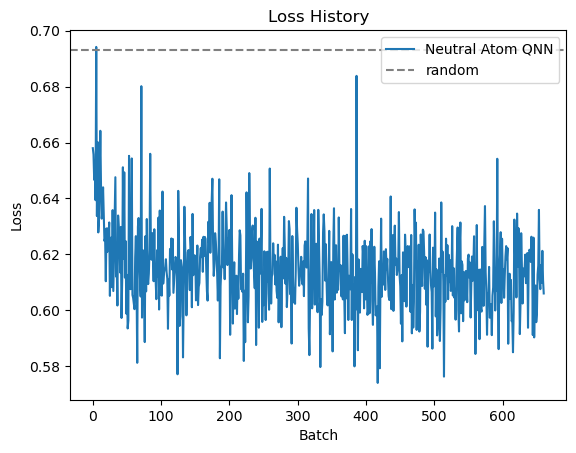

In [25]:
plt.plot(losses_hist, label="Neutral Atom QNN")
plt.axhline(-np.log(0.5), ls="--", c="gray", label="random")
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

Text(0.5, 1.0, 'Omega History')

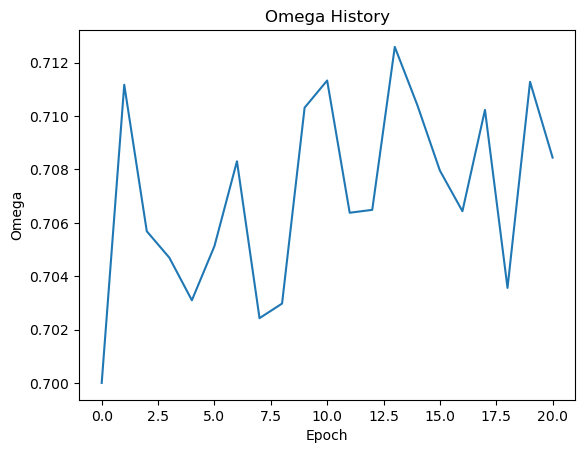

In [18]:
plt.plot(global_pulse_omega_hist)
plt.xlabel('Epoch')
plt.ylabel('Omega')
plt.title('Omega History')

Text(0.5, 1.0, 'Omega History')

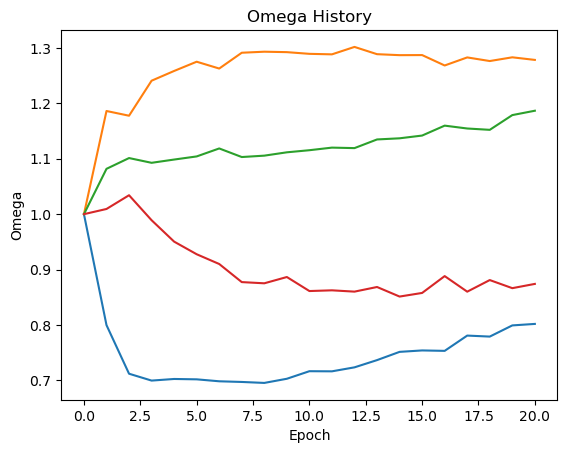

In [19]:
plt.plot(local_pulses_omega_hist)
plt.xlabel('Epoch')
plt.ylabel('Omega')
plt.title('Omega History')

Text(0.5, 1.0, 'Neutral atoms positions moving as function of epochs')

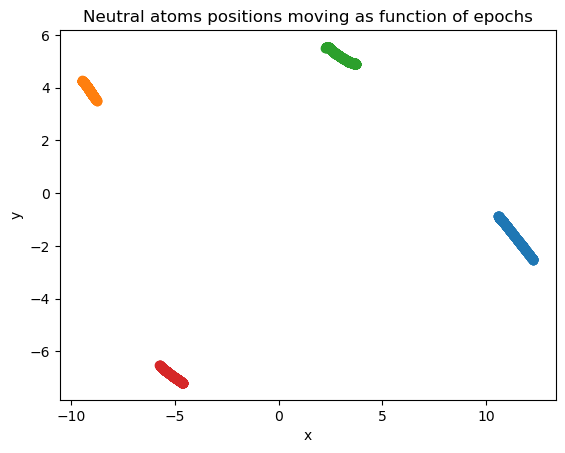

In [28]:
pos_hist_arr = np.array(positions_hist)
plt.plot(pos_hist_arr[:, 0, 0], pos_hist_arr[:, 0, 1])
plt.scatter(pos_hist_arr[:, 0, 0], pos_hist_arr[:, 0, 1])
plt.plot(pos_hist_arr[:, 1, 0], pos_hist_arr[:, 1, 1])
plt.scatter(pos_hist_arr[:, 1, 0], pos_hist_arr[:, 1, 1])
plt.plot(pos_hist_arr[:, 2, 0], pos_hist_arr[:, 2, 1])
plt.scatter(pos_hist_arr[:, 2, 0], pos_hist_arr[:, 2, 1])
plt.plot(pos_hist_arr[:, 3, 0], pos_hist_arr[:, 3, 1])
plt.scatter(pos_hist_arr[:, 3, 0], pos_hist_arr[:, 3, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Neutral atoms positions moving as function of epochs")

In [29]:
print(f"{positions_hist[-1]=}")
print(f"{local_pulses_omega=}")
print(f"{local_pulses_delta=}")
print(f"{global_pulse_omega=}")
print(f"{global_pulse_delta=}")

positions_hist[-1]=array([[10.62903462, -0.91553049],
       [-9.46002619,  4.27328964],
       [ 3.71150081,  4.91594491],
       [-4.61605898, -7.19239136]])
local_pulses_omega=tensor([0.8016, 1.2782, 1.1775, 0.8681], requires_grad=True)
local_pulses_delta=tensor([0.6494, 0.1647, 0.5394, 0.7927], requires_grad=True)
global_pulse_omega=tensor(0.7036, requires_grad=True)
global_pulse_delta=tensor(0.5370, requires_grad=True)


In [ ]:
epochs_cont = 50
for epoch in range(epochs_cont):
    print(f"Epoch {epoch+1}/{epochs_cont}")
    for i_batch, batch in enumerate(small_train_loader):
        print(f"Batch {i_batch+1}/{len(small_train_loader)}")
        x_batch, y_batch = batch
        optimizer.zero_grad()
        l = torch.tensor(0.0, requires_grad=False)
        y_pred_batch = []
        for i in range(len(x_batch)):
            print(f"Processing sample {i+1}/{len(x_batch)}", end='\r')
            out, states = run_model(x_batch[i], positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta,
                            local_pulse_duration=local_pulse_duration, global_pulse_duration=global_pulse_duration, 
                            embed_pulse_duration=embed_pulse_duration,
                            draw_reg_seq=False)
            loss = loss_fn(out, y_batch[i:i+1].to(torch.float64)) # needs float64 here
            y_pred_batch.append(out.item())
            l += loss
            # save parameters and output to file
            with open(data_save_file, 'a') as f:
                # f.write(f"{positions.tolist()};{local_pulses_omega.tolist()};{local_pulses_delta.tolist()}; {global_pulse_omega.item()};{global_pulse_delta.item()};{states[-1].tolist()};{out.item()};{x_batch[i].tolist()};{y_batch[i].item()}\n")
                f.write(f"{sampling_rate};{local_pulse_duration};{global_pulse_duration};{embed_pulse_duration};"
                        f"{positions.tolist()};{local_pulses_omega.tolist()};{local_pulses_delta.tolist()};"
                        f"{global_pulse_omega.item()};{global_pulse_delta.item()};{states[-1].tolist()};"
                        f"{out.item()};{x_batch[i].tolist()};{y_batch[i].item()}\n")

        l /= len(x_batch)
        l.backward()
        optimizer.step()
        losses_hist.append(l.item())
        positions_hist.append(positions.clone().detach().numpy())
        # calculate accuracy for the batch
        targets = y_batch.numpy()
        predictions = np.array(y_pred_batch)
        predictions = np.where(predictions > 0.5, 1, 0)  # Convert to binary predictions
        correct_predictions = np.sum(predictions == targets)
        accuracy = correct_predictions / len(targets)
        accuracies_hist.append(accuracy)
        print(f"Batch {i_batch}, Loss: {l.item()}, Accuracy: {accuracy:.4f}")
    local_pulses_omega_hist.append(local_pulses_omega.clone().detach().numpy())
    local_pulses_delta_hist.append(local_pulses_delta.clone().detach().numpy())
    global_pulse_omega_hist.append(global_pulse_omega.clone().detach().numpy())
    global_pulse_delta_hist.append(global_pulse_delta.clone().detach().numpy())
        # print(f"gradients: {positions.grad}, {local_pulses_omega.grad}, {local_pulses_delta.grad}, {global_pulse_omega.grad}, {global_pulse_delta.grad}")
    # print(f"Epoch {epoch+1}, Loss: {l.item()}")

Epoch 1/50
Batch 1/32
Batch 0, Loss: 0.6070921421051025, Accuracy: 0.9062
Batch 2/32
Batch 1, Loss: 0.5983802080154419, Accuracy: 0.8750
Batch 3/32
Batch 2, Loss: 0.6111133098602295, Accuracy: 0.7812
Batch 4/32
Batch 3, Loss: 0.5891870260238647, Accuracy: 0.8750
Batch 5/32
Batch 4, Loss: 0.5966547131538391, Accuracy: 0.8438
Batch 6/32
Batch 5, Loss: 0.6437366604804993, Accuracy: 0.5938
Batch 7/32
Batch 6, Loss: 0.5872019529342651, Accuracy: 0.8750
Batch 8/32
Batch 7, Loss: 0.6117745041847229, Accuracy: 0.8125
Batch 9/32
Batch 8, Loss: 0.6156383156776428, Accuracy: 0.8125
Batch 10/32
Batch 9, Loss: 0.6228141784667969, Accuracy: 0.7500
Batch 11/32
Batch 10, Loss: 0.5951687693595886, Accuracy: 0.9062
Batch 12/32
Batch 11, Loss: 0.6120772957801819, Accuracy: 0.8750
Batch 13/32
Batch 12, Loss: 0.614321768283844, Accuracy: 0.8438
Batch 14/32
Batch 13, Loss: 0.6363312005996704, Accuracy: 0.7812
Batch 15/32
Batch 14, Loss: 0.5816911458969116, Accuracy: 0.9375
Batch 16/32
Batch 15, Loss: 0.6016

In [ ]:
plt.plot(losses_hist)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss History')

In [ ]:
plt.plot(global_pulse_omega_hist)
plt.xlabel('Epoch')
plt.ylabel('Omega')
plt.title('Omega History')

In [ ]:
plt.plot(local_pulses_omega_hist)
plt.xlabel('Epoch')
plt.ylabel('Omega')
plt.title('Omega History')

In [ ]:
positions_hist_arr = np.array(positions_hist)
plt.plot(positions_hist_arr[:, 0, 0], positions_hist_arr[:, 0, 1])
plt.scatter(positions_hist_arr[:, 0, 0], positions_hist_arr[:, 0, 1])
plt.plot(positions_hist_arr[:, 1, 0], positions_hist_arr[:, 1, 1])
plt.scatter(positions_hist_arr[:, 1, 0], positions_hist_arr[:, 1, 1])
plt.plot(positions_hist_arr[:, 2, 0], positions_hist_arr[:, 2, 1])
plt.scatter(positions_hist_arr[:, 2, 0], positions_hist_arr[:, 2, 1])
plt.plot(positions_hist_arr[:, 3, 0], positions_hist_arr[:, 3, 1])
plt.scatter(positions_hist_arr[:, 3, 0], positions_hist_arr[:, 3, 1])

In [ ]:
print(f"{positions_hist[-1]=}")
print(f"{local_pulses_omega=}")
print(f"{local_pulses_delta=}")
print(f"{global_pulse_omega=}")
print(f"{global_pulse_delta=}")